In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import normal
%matplotlib inline

In [2]:
#------------#
# Parameters #
#------------#
N=10            # サンプルを取得する位置 x の個数
M=[0,1,3,9]     # 多項式の次数


In [3]:
# データセット {x_n,y_n} (n=1...N) を用意
def create_dataset(num):
    dataset = DataFrame(columns=['x','y'])
    for i in range(num):
        x = float(i)/float(num-1)
        y = np.sin(2*np.pi*x) + normal(scale=0.3)
        dataset = dataset.append(Series([x,y], index=['x','y']),
                                 ignore_index=True)
    return dataset

In [4]:
# 最大対数尤度（Maximum log likelihood）を計算
def log_likelihood(dataset, f):
    dev = 0.0
    n = float(len(dataset))
    for index, line in dataset.iterrows():
        x, y = line.x, line.y
        dev += (y - f(x))**2
    err = dev * 0.5
    beta = n / dev
    lp = -beta*err + 0.5*n*np.log(0.5*beta/np.pi)
    return lp

In [5]:
# 最尤推定で解を求める（解法は最小二乗法と同じ）
def resolve(dataset, m):
    t = dataset.y
    phi = DataFrame()
    for i in range(0,m+1):
        p = dataset.x**i
        p.name="x**%d" % i
        phi = pd.concat([phi,p], axis=1)
    tmp = np.linalg.inv(np.dot(phi.T, phi))
    ws = np.dot(np.dot(tmp, phi.T), t)

    def f(x):
        y = 0.0
        for i, w in enumerate(ws):
            y += w * (x ** i)
        return y

    sigma2 = 0.0
    for index, line in dataset.iterrows():
        sigma2 += (f(line.x)-line.y)**2
    sigma2 /= len(dataset)

    return (f, ws, np.sqrt(sigma2))

/Users/arimuraterutoshi/.pyenv/versions/anaconda3-2.4.1/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


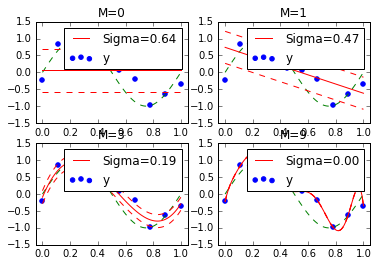

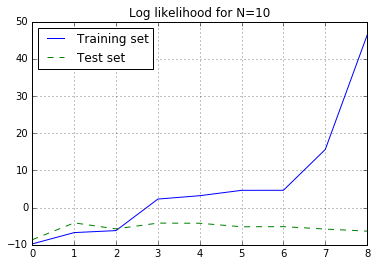

In [7]:
train_set = create_dataset(N)
test_set = create_dataset(N)
df_ws = DataFrame()
# 多項式近似の曲線を求めて表示
fig = plt.figure()
for c, m in enumerate(M):
    f, ws, sigma = resolve(train_set, m)
    df_ws = df_ws.append(Series(ws,name="M=%d" % m))
    subplot = fig.add_subplot(2,2,c+1)
    subplot.set_xlim(-0.05,1.05)
    subplot.set_ylim(-1.5,1.5)
    subplot.set_title("M=%d" % m)
    # トレーニングセットを表示
    subplot.scatter(train_set.x, train_set.y, marker='o', color='blue')
    # 真の曲線を表示
    linex = np.linspace(0,1,101)
    liney = np.sin(2*np.pi*linex)
    subplot.plot(linex, liney, color='green', linestyle='--')
    # 多項式近似の曲線を表示
    linex = np.linspace(0,1,101)
    liney = f(linex)
    label = "Sigma=%.2f" % sigma
    subplot.plot(linex, liney, color='red', label=label)
    subplot.plot(linex, liney+sigma, color='red', linestyle='--')
    subplot.plot(linex, liney-sigma, color='red', linestyle='--')
    subplot.legend(loc=1)
fig.show()
# 多項式近似に対する最大対数尤度を計算
df = DataFrame()
train_mlh = []
test_mlh = []
for m in range(0,9): # 多項式の次数
    f, ws, sigma = resolve(train_set, m)
    train_mlh.append(log_likelihood(train_set, f))
    test_mlh.append(log_likelihood(test_set, f))
df = pd.concat([df,
                DataFrame(train_mlh, columns=['Training set']),
                DataFrame(test_mlh, columns=['Test set'])],
                axis=1)
df.plot(title='Log likelihood for N=%d' % N, grid=True, style=['-','--'])
plt.show()